# Artifact Removal Strategies

GastroPy provides three composable time-domain preprocessing functions
that remove artifacts from the raw EGG signal **before** bandpass filtering,
plus a named pipeline variant in `egg_clean` that bundles them together.

| Function | Method | Reference |
|---|---|---|
| `hampel_filter` | Sliding-window median; replaces spikes with local median | Davies & Gather (1993); Dalmaijer (2025) |
| `mad_filter` | Global MAD outlier replacement; faster, less adaptive | Dalmaijer (2025) |
| `remove_movement_artifacts` | LMMSE Wiener filter for movement noise | Gharibans et al. (2018) |
| `egg_clean(..., method="dalmaijer2025")` | Hampel → LMMSE → IIR Butterworth pipeline | Dalmaijer (2025) |

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import gastropy as gp

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

# Synthetic EGG: gastric sine + pink noise + injected spike
rng = np.random.default_rng(42)
sfreq = 10.0
t = np.arange(0, 300, 1.0 / sfreq)
gastric = np.sin(2 * np.pi * 0.05 * t)           # 3 cpm signal
noise = 0.3 * rng.standard_normal(len(t))          # background noise
movement = 0.5 * np.sin(2 * np.pi * 0.008 * t)    # slow drift / movement
signal = gastric + noise + movement

# Inject two large spike artifacts
signal[300] = 8.0
signal[1800] = -7.5

print(f"Signal length : {len(signal)} samples ({len(signal)/sfreq:.0f} s)")
print(f"Signal range  : [{signal.min():.2f}, {signal.max():.2f}]")

Signal length : 3000 samples (300 s)
Signal range  : [-7.50, 8.00]


## Hampel Filter — Spike Removal

`hampel_filter` slides a window of length `2k+1` across the signal.
Any sample deviating from the local median by more than
`n_sigma × 1.4826 × MAD` is replaced by that median.

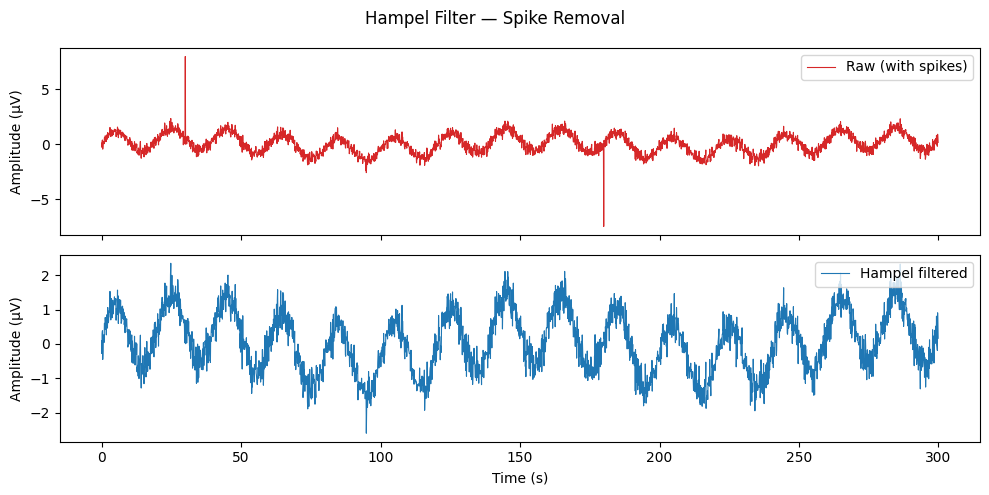

Max absolute value before: 8.00
Max absolute value after : 2.59


In [2]:
hampel_cleaned = gp.hampel_filter(signal, k=5, n_sigma=3.0)

fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
axes[0].plot(t, signal, lw=0.8, color="#d62728", label="Raw (with spikes)")
axes[0].set_ylabel("Amplitude (µV)")
axes[0].legend(loc="upper right")
axes[1].plot(t, hampel_cleaned, lw=0.8, color="#1f77b4", label="Hampel filtered")
axes[1].set_ylabel("Amplitude (µV)")
axes[1].set_xlabel("Time (s)")
axes[1].legend(loc="upper right")
fig.suptitle("Hampel Filter — Spike Removal")
plt.tight_layout()
plt.show()

print(f"Max absolute value before: {np.abs(signal).max():.2f}")
print(f"Max absolute value after : {np.abs(hampel_cleaned).max():.2f}")

## MAD Filter — Global Outlier Removal

`mad_filter` computes a single global median and MAD across the entire
signal. Faster than `hampel_filter` but less adaptive to slow signal
drift. Suitable as a quick first pass on stationary recordings.

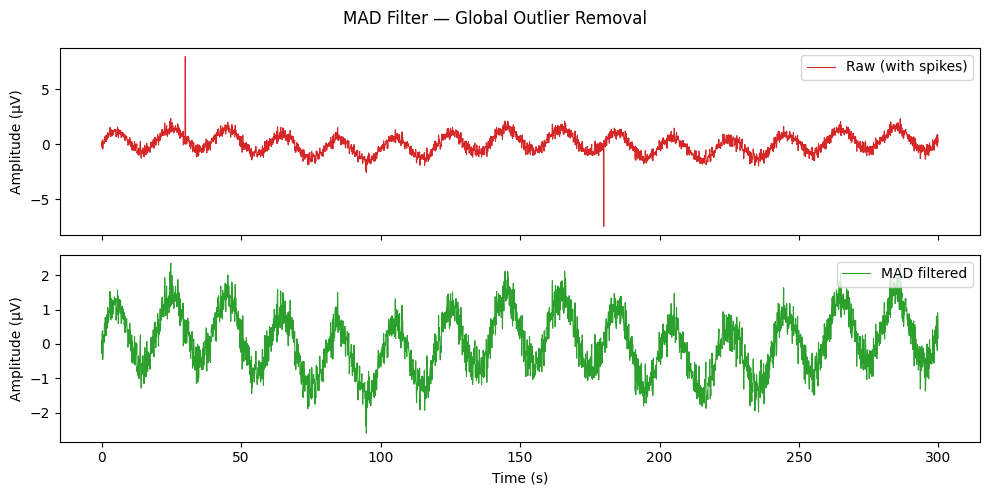

Max absolute value after MAD filter: 2.59


In [3]:
mad_cleaned = gp.mad_filter(signal, n_sigma=3.0)

fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
axes[0].plot(t, signal, lw=0.8, color="#d62728", label="Raw (with spikes)")
axes[0].set_ylabel("Amplitude (µV)")
axes[0].legend(loc="upper right")
axes[1].plot(t, mad_cleaned, lw=0.8, color="#2ca02c", label="MAD filtered")
axes[1].set_ylabel("Amplitude (µV)")
axes[1].set_xlabel("Time (s)")
axes[1].legend(loc="upper right")
fig.suptitle("MAD Filter — Global Outlier Removal")
plt.tight_layout()
plt.show()

print(f"Max absolute value after MAD filter: {np.abs(mad_cleaned).max():.2f}")

## Movement Artifact Filter — LMMSE

`remove_movement_artifacts` applies an LMMSE Wiener-filter that
estimates local variance in sliding windows and attenuates time segments
where variance exceeds the expected signal variance. Effective for
movement and drift artifacts (Gharibans et al., 2018).

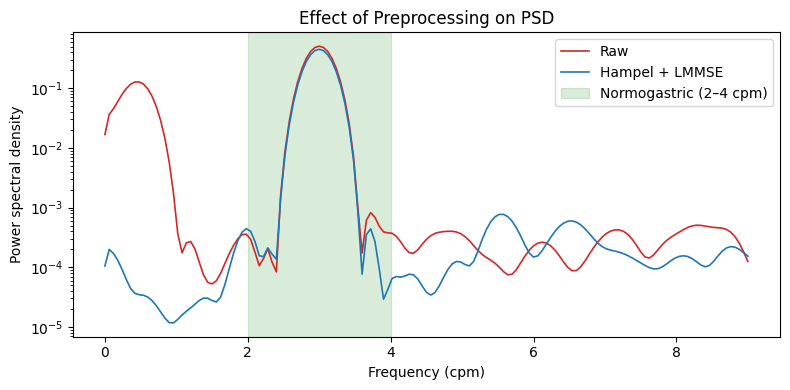

In [4]:
# First remove spikes, then attenuate movement artifacts
spike_cleaned = gp.hampel_filter(signal, k=5)
movement_cleaned = gp.remove_movement_artifacts(spike_cleaned, sfreq=sfreq, freq=0.05)

# Compare PSDs
freqs_raw, psd_raw = gp.psd_welch(signal, sfreq, fmin=0.0, fmax=0.15, overlap=0.75)
freqs_clean, psd_clean = gp.psd_welch(movement_cleaned, sfreq, fmin=0.0, fmax=0.15, overlap=0.75)

fig, ax = plt.subplots(figsize=(8, 4))
ax.semilogy(freqs_raw * 60, psd_raw, color="#d62728", lw=1.2, label="Raw")
ax.semilogy(freqs_clean * 60, psd_clean, color="#1f77b4", lw=1.2, label="Hampel + LMMSE")
ax.axvspan(2, 4, alpha=0.15, color="green", label="Normogastric (2–4 cpm)")
ax.set_xlabel("Frequency (cpm)")
ax.set_ylabel("Power spectral density")
ax.set_title("Effect of Preprocessing on PSD")
ax.legend()
plt.tight_layout()
plt.show()

## Dalmaijer 2025 — Bundled Pipeline

`egg_clean(method="dalmaijer2025")` runs Hampel → LMMSE → IIR
Butterworth as a single named pipeline. Compare with the default FIR
bandpass on the same noisy signal.

FIR pipeline:
  filter_method : fir
  numtaps       : 501

Dalmaijer 2025 pipeline:
  cleaning_method : dalmaijer2025
  hampel_k        : 3
  movement_window : 1.0 cycles
  filter_method   : iir_butter


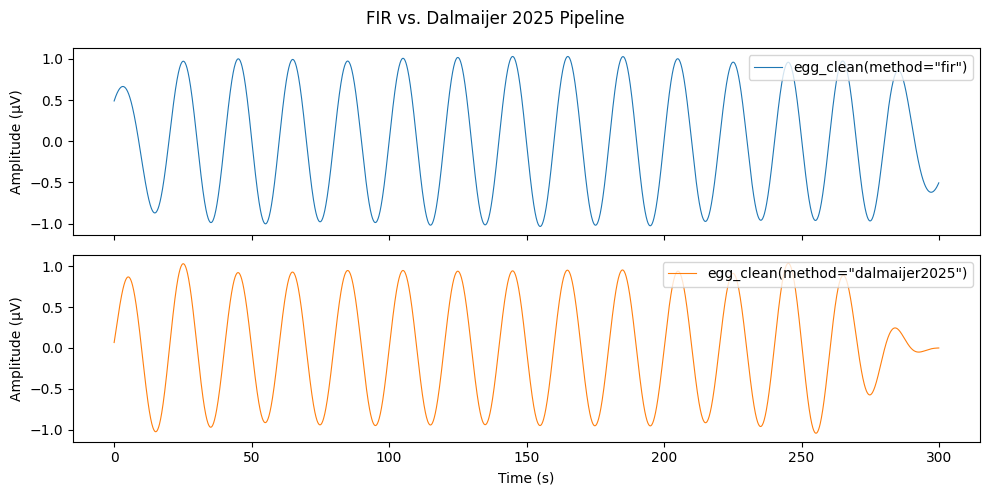

In [5]:
cleaned_fir, info_fir = gp.egg_clean(signal, sfreq=sfreq, method="fir")
cleaned_d25, info_d25 = gp.egg_clean(signal, sfreq=sfreq, method="dalmaijer2025")

print("FIR pipeline:")
print(f"  filter_method : {info_fir['filter_method']}")
print(f"  numtaps       : {info_fir['fir_numtaps']}")

print("\nDalmaijer 2025 pipeline:")
print(f"  cleaning_method : {info_d25['cleaning_method']}")
print(f"  hampel_k        : {info_d25['hampel_k']}")
print(f"  movement_window : {info_d25['movement_window']} cycles")
print(f"  filter_method   : {info_d25['filter_method']}")

fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
axes[0].plot(t, cleaned_fir, lw=0.8, color="#1f77b4", label='egg_clean(method="fir")')
axes[0].set_ylabel("Amplitude (µV)")
axes[0].legend(loc="upper right")
axes[1].plot(t, cleaned_d25, lw=0.8, color="#ff7f0e", label='egg_clean(method="dalmaijer2025")')
axes[1].set_ylabel("Amplitude (µV)")
axes[1].set_xlabel("Time (s)")
axes[1].legend(loc="upper right")
fig.suptitle("FIR vs. Dalmaijer 2025 Pipeline")
plt.tight_layout()
plt.show()

**See also:**
[Bandpass Filtering](bandpass_filtering.ipynb),
[One-Call EGG Pipeline](egg_process.ipynb),
[Multi-Channel Processing](multichannel_processing.ipynb),
[Artifact Detection](plot_artifacts.ipynb)